In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from skimage import img_as_float, io
import os
import glob

C:\Users\Arman\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
labels = ['crampons', 'tents', 'boots', 'gloves', 'pulleys', 'carabiners', 
          'axes', 'harnesses', 'hardshell_jackets', 'rope', 'helmets', 'insulated_jackets']

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(labels)

LabelEncoder()

In [3]:
def process_images(main_folder):
    x = np.load(os.path.join(main_folder, "x_image_arrays.npy"))
    y = np.load(os.path.join(main_folder, "y_image_labels.npy"))
    num_classes = len(np.unique(y))
    x /= 255
    y_enc = label_encoder.transform(y)
    y_cat = to_categorical(y_enc)
    input_shape = x[0].shape
    return x, y_cat, input_shape, num_classes

In [4]:
def get_train_test(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=13)
    return x_train, x_test, y_train, y_test

In [5]:
def createModel(input_shape, num_classes, kernel_size):
    model = Sequential()
    
    model.add(Conv2D(filters = 32, kernel_size = (kernel_size, kernel_size), activation='relu', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 32, kernel_size = (kernel_size, kernel_size), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=(2,2)))
    model.add(Dropout(0.10))

    model.add(Conv2D(filters = 32, kernel_size = (kernel_size, kernel_size), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 32, kernel_size = (kernel_size, kernel_size), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(strides=(2,2)))
    model.add(Dropout(0.10))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [6]:
def trainModel(input_shape, num_classes, batch_size, epochs, x_train, x_test, 
               y_train, y_test, train_generator, kernel_size):
    
    model = createModel(input_shape, num_classes, kernel_size)
    model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])
    annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
    
    history = model.fit_generator(
                train_generator,
                steps_per_epoch= x_train.shape[0]  // batch_size,
                epochs=epochs,
                validation_data=(x_test, y_test),
                callbacks=[annealer])
    
    score = model.evaluate(x_test, y_test, verbose=1)
    print("Model Accuracy:" + str(history.history['acc'][-1]))
    print("Validation Accuracy:" + str(history.history['val_acc'][-1]))
    return history, model

In [7]:
def plot_loss(history):
    plt.figure(figsize=[8,6])
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)

def plot_accuracy(history):
    plt.figure(figsize=[8,6])
    plt.plot(history.history['acc'],'r',linewidth=3.0)
    plt.plot(history.history['val_acc'],'b',linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=12)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)

In [8]:
def generate_images(x_train, x_test, y_train, y_test, batch_size):
    train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
    
    train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
    return train_generator 

In [9]:
def main(main_folder, batch_size, epochs, kernel_size):
    print("Model batch_size: " + str(batch_size) + " Epochs: " + str(epochs) + " Kernel Size: " + str(kernel_size))
    x, y, input_shape, num_classes = process_images(main_folder)
    x_train, x_test, y_train, y_test = get_train_test(x, y)
    
    train_generator = generate_images(x_train, x_test, y_train, y_test, batch_size)
    history, model = trainModel(input_shape, num_classes, batch_size, epochs, x_train, x_test, 
                       y_train, y_test, train_generator, kernel_size)
    plot_loss(history)
    plot_accuracy(history)
    filepath = main_folder + "/model_2_" + str(batch_size) + "_" + str(epochs) + ".h5"
    model.save(filepath)

Model batch_size: 32 Epochs: 30 Kernel Size: 5
Epoch 1/30
53/53 [==============================] - 14s 271ms/step - loss: 3.7863 - acc: 0.5924 - val_loss: 12.5650 - val_acc: 0.1859
Epoch 2/30
53/53 [==============================] - 15s 277ms/step - loss: 1.4548 - acc: 0.7281 - val_loss: 5.8787 - val_acc: 0.2235
Epoch 3/30
53/53 [==============================] - 16s 296ms/step - loss: 0.8393 - acc: 0.7776 - val_loss: 3.2444 - val_acc: 0.6212
Epoch 4/30
53/53 [==============================] - 15s 292ms/step - loss: 0.6633 - acc: 0.7957 - val_loss: 8.7288 - val_acc: 0.2894
Epoch 5/30
53/53 [==============================] - 16s 293ms/step - loss: 0.6417 - acc: 0.8313 - val_loss: 5.9421 - val_acc: 0.4471
Epoch 6/30
53/53 [==============================] - 16s 296ms/step - loss: 0.4727 - acc: 0.8543 - val_loss: 1.5279 - val_acc: 0.7271
Epoch 7/30
53/53 [==============================] - 15s 289ms/step - loss: 0.3094 - acc: 0.8897 - val_loss: 0.6072 - val_acc: 0.7976
Epoch 8/30
53/53 [===

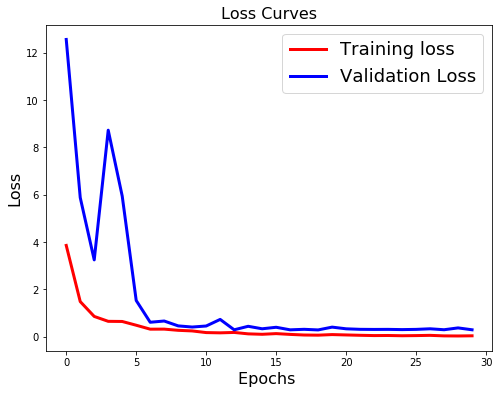

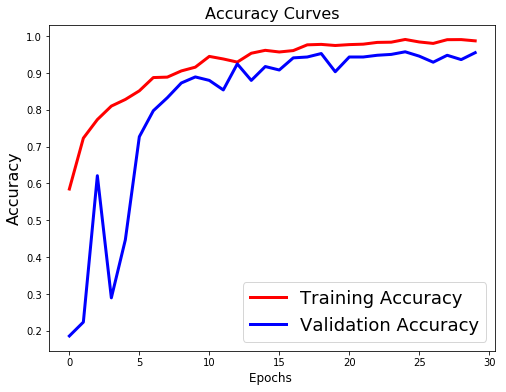

In [10]:
main("C:\\Users\\Arman\\Downloads\\openhack_toronto", 32, 30, 5)